In [82]:
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

In [2]:
usr_sub = pd.read_csv('usr_sub.csv')

In [5]:
usr_counters = pd.read_csv('usr_counters.csv')

In [9]:
# drop this as there are many None values
# idk what does it mean, so drop it for now
usr_counters = usr_counters.drop(columns=['user_photos', 'gifts'])

In [10]:
ohe_usr_sub = pd.read_csv('onehot_usr_sub.csv')

In [11]:
ohe_usr_sub

,user_id,27,28,41,47,65,272,299,337,439,...,202588677,202591514,202597077,202632157,202663824,202682637,202701885,202729930,202737287,202839873
0,17680,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,82824,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,137642,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,210164,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,266484,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2467,544446835,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2468,568860573,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2469,569106575,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2470,587338436,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [14]:
data = usr_counters.fillna(0).astype(int).merge(ohe_usr_sub)

In [18]:
with sqlite3.connect('data.sqlite3') as conn:
    userfac = pd.read_sql_query('''
select faculty_id, user_id from users_faculties
where faculty_id in (select id from faculties)
''', con=conn)

In [20]:
userfac[
    userfac['user_id'].astype(int).isin(data['user_id'])
]['faculty_id'].nunique()

33

In [29]:
ufac = userfac[~userfac.duplicated()
        &
        userfac['faculty_id'].isin(['2973', '2161062', '2231790',
                                    '2231275', '2231267', '2173844',
                                    '20422'])
        &
        userfac['user_id'].astype(int).isin(data['user_id'])
              ]

In [30]:
ufac = ufac.astype(int)

In [36]:
# maybe not to remove and keep user values from differect faculties
ufac_no_dups = ufac[~ufac['user_id'].duplicated()]

In [39]:
res = data.merge(ufac_no_dups, on='user_id').drop(columns='user_id')

In [40]:
res

,friends,albums,audios,followers,27,28,41,47,65,272,...,202591514,202597077,202632157,202663824,202682637,202701885,202729930,202737287,202839873,faculty_id
0,3026,1,21,6491,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2973
1,338,7,746,406,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,20422
2,421,16,175,214,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2161062
3,267,20,5116,179,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2973
4,180,0,144,104,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2973
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2467,187,0,1848,90,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2231275
2468,142,0,0,540,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2173844
2469,6,0,7,6,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2173844
2470,150,4,27,142,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2161062


In [98]:
res_x = res.drop(columns=['faculty_id'])
res_y = res['faculty_id']

In [99]:
X_train, X_test, y_train, y_test = train_test_split(res_x, res_y)

In [100]:
clf = GaussianNB()

In [101]:
clf.fit(X_train, y_train)

GaussianNB()

In [102]:
y_pred = clf.predict(X_test)

In [103]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

        2973       0.28      0.74      0.40        78
       20422       0.56      0.16      0.25        92
     2161062       0.30      0.19      0.23        94
     2173844       0.44      0.28      0.35        81
     2231267       0.46      0.57      0.51        84
     2231275       0.45      0.44      0.44       102
     2231790       0.50      0.37      0.42        87

    accuracy                           0.39       618
   macro avg       0.43      0.39      0.37       618
weighted avg       0.43      0.39      0.37       618



In [97]:
print(confusion_matrix(y_test, y_pred))

[[55  2  5  6  2  5  1]
 [24  8 12  9  5 21  6]
 [38  5 21 10 12 16  4]
 [28  1  2 26  3  1 12]
 [12  3  7  6 38 11  8]
 [37  7  2  2  9 28  9]
 [13  1  5 16 10  5 49]]


In [68]:
pca = PCA(n_components=3)

In [69]:
pca.fit(X_train)

PCA(n_components=3)

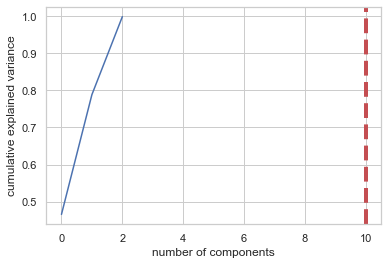

None

In [70]:
sns.set(style='whitegrid')
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.axvline(linewidth=4, color='r', linestyle = '--', x=10, ymin=0, ymax=1)
display(plt.show())

In [71]:
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)

In [74]:
rfc = RandomForestClassifier()

In [75]:
rfc.fit(X_train_pca, y_train)

RandomForestClassifier()

In [76]:
y_pred = rfc.predict(X_test_pca)

In [77]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

        2973       0.44      0.45      0.44        83
       20422       0.24      0.20      0.22        93
     2161062       0.20      0.21      0.20        92
     2173844       0.06      0.04      0.05        90
     2231267       0.23      0.18      0.20       101
     2231275       0.22      0.27      0.24        85
     2231790       0.16      0.23      0.19        74

    accuracy                           0.22       618
   macro avg       0.22      0.23      0.22       618
weighted avg       0.22      0.22      0.22       618



In [78]:
from sklearn.linear_model import LogisticRegression

In [79]:
lr = LogisticRegression()

In [80]:
C = [float(x) for x in range(1, 1000, 10)]

In [84]:
gs = GridSearchCV(lr, {'C': C}, cv = 3, verbose = 1, n_jobs=-1)
gs.fit(X_train_pca, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


GridSearchCV(cv=3, estimator=LogisticRegression(), n_jobs=-1,
             param_grid={'C': [1.0, 11.0, 21.0, 31.0, 41.0, 51.0, 61.0, 71.0,
                               81.0, 91.0, 101.0, 111.0, 121.0, 131.0, 141.0,
                               151.0, 161.0, 171.0, 181.0, 191.0, 201.0, 211.0,
                               221.0, 231.0, 241.0, 251.0, 261.0, 271.0, 281.0,
                               291.0, ...]},
             verbose=1)

In [85]:
gs.best_params_

{'C': 111.0}

In [86]:
lr = LogisticRegression(C=111.0)

In [87]:
lr.fit(X_train_pca, y_train)

LogisticRegression(C=111.0)

In [88]:
y_pred = lr.predict(X_test_pca)

In [89]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

        2973       0.20      0.13      0.16        83
       20422       0.32      0.08      0.12        93
     2161062       0.16      0.08      0.10        92
     2173844       0.00      0.00      0.00        90
     2231267       0.22      0.08      0.12       101
     2231275       0.16      0.55      0.24        85
     2231790       0.21      0.45      0.28        74

    accuracy                           0.18       618
   macro avg       0.18      0.19      0.15       618
weighted avg       0.18      0.18      0.14       618



S:\Users\Администратор\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
S:\Users\Администратор\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
S:\Users\Администратор\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.